In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#unzip -uq "/content/drive/MyDrive/Dataset.zip" -d "/content/drive/MyDrive/"

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import os
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pylab as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sn


In [ ]:
train_dir='/content/drive/MyDrive/Dataset'

In [ ]:
Labels = ['Benign', 'Malignant']

In [ ]:
print ("class : ") 
for i in range(len(Labels)): 
    print (i, end = " ") 
    print (Labels[i]) 

class : 
0 Benign
1 Malignant


In [ ]:
print('Number of classes:',len(Labels))

Number of classes: 2


Here we are using efficientnetv2 instead of mobilenet

In [ ]:
module_selection = ("efficientnetv2-s-21k", 224, 1280) 
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/classification/2"
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 16

In [ ]:
IMAGE_SIZE

(224, 224)

In [ ]:
# Here we are going to use a bigger data augmentation that in the original project :
# We are gonna add brightness range, Vertical Flip.

In [ ]:
# Here in the data augmentation, we have added horizontal_flip and brightness range 
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      vertical_flip = True,
      width_shift_range=0.2,
      brightness_range = [0.5,1.2], 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest',
      validation_split=0.4)
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

validation_generator = train_datagen.flow_from_directory(
    train_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    subset="validation",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE) 

Found 24 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [ ]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,input_shape=IMAGE_SIZE+(3,), output_shape=[FV_SIZE])
print("Building model with", MODULE_HANDLE)
base_model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
print('Frozen model')
base_model.summary()
feature_extractor.trainable = True
for layer in base_model.layers:
  layer.trainable =True

print('''


''')
print('Model After unfreezing')
base_model.summary()


Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/classification/2
Frozen model
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_6 (KerasLayer)  (None, 21843)             48312243  
                                                                 
 flatten_6 (Flatten)         (None, 21843)             0         
                                                                 
 dense_12 (Dense)            (None, 512)               11184128  
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 59,497,397
Trainable params: 11,185,154
Non-trainable para

In [ ]:
# Same but for Frozen model 
feature_extractor = hub.KerasLayer(MODULE_HANDLE,input_shape=IMAGE_SIZE+(3,), output_shape=[FV_SIZE])
print("Building model with", MODULE_HANDLE)
base_model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
feature_extractor.trainable = False

Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/classification/2


In [ ]:
base_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_7 (KerasLayer)  (None, 21843)             48312243  
                                                                 
 flatten_7 (Flatten)         (None, 21843)             0         
                                                                 
 dense_14 (Dense)            (None, 512)               11184128  
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 59,497,397
Trainable params: 11,185,154
Non-trainable params: 48,312,243
_________________________________________________________________


The original model had only 11,185,154 trainable parameters, now we have 59,343,525. 

In [ ]:
#from efficientnet.tfkeras import EfficientNetB2


# Get the input layer of the pre-trained model
inputs = base_model.input

# Add batch normalization layer as the first layer
x = BatchNormalization()(inputs)

# Add the rest of the layers of the pre-trained model
x = base_model(x)
# Create a weight decay regularizer
weight_decay = 1e-5
reg = l2(weight_decay)

#Add weight decay to all layers in the model
for layer in base_model.layers:
  if hasattr(layer, 'kernel_regularizer'):
        layer.kernel_regularizer = reg

model = Model(inputs, x)
# Create an early stopping callback, since our dataset is really small, to observe the pertinence of the early stopping, we will set a patience to 15 and will work on 100 epochs.
early_stopping = EarlyStopping(monitor='val_loss', patience=20)



In [ ]:
LEARNING_RATE = 0.001 
base_model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

In [ ]:
# Compile the model and train it
LEARNING_RATE = 0.001 
base_model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])


# Training for Frozen model

In [ ]:
EPOCHS=100

history = base_model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size,
        callbacks=[early_stopping])

Epoch 1/100
1/1 [==============================] - 16s 16s/step - loss: 1.5297 - accuracy: 0.3750 - val_loss: 50.4775 - val_accuracy: 0.5000
Epoch 2/100
1/1 [==============================] - 1s 807ms/step - loss: 37.2356 - accuracy: 0.5000 - val_loss: 30.5103 - val_accuracy: 0.6250
Epoch 3/100
1/1 [==============================] - 3s 3s/step - loss: 14.2701 - accuracy: 0.6875 - val_loss: 25.5657 - val_accuracy: 0.6875
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 24.9805 - accuracy: 0.6875 - val_loss: 0.0095 - val_accuracy: 1.0000
Epoch 5/100
1/1 [==============================] - 1s 1s/step - loss: 3.8760e-04 - accuracy: 1.0000 - val_loss: 26.5917 - val_accuracy: 0.6250
Epoch 6/100
1/1 [==============================] - 1s 715ms/step - loss: 11.5341 - accuracy: 0.8750 - val_loss: 28.6358 - val_accuracy: 0.5000
Epoch 7/100
1/1 [==============================] - 1s 678ms/step - loss: 1.0054 - accuracy: 0.8750 - val_loss: 14.9888 - val_accuracy: 0.6875
Epoch 8/1

# Training for Unfrozen model

In [ ]:
EPOCHS=100

history = base_model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size,
        callbacks=[early_stopping])

Epoch 1/100
1/1 [==============================] - 25s 25s/step - loss: 2.2291 - accuracy: 0.2500 - val_loss: 26.0293 - val_accuracy: 0.3750
Epoch 2/100
1/1 [==============================] - 1s 988ms/step - loss: 11.8440 - accuracy: 0.6250 - val_loss: 19.9278 - val_accuracy: 0.5625
Epoch 3/100
1/1 [==============================] - 1s 1s/step - loss: 38.8640 - accuracy: 0.6250 - val_loss: 69.1264 - val_accuracy: 0.5000
Epoch 4/100
1/1 [==============================] - 1s 1s/step - loss: 3.8287e-04 - accuracy: 1.0000 - val_loss: 111.8457 - val_accuracy: 0.5000
Epoch 5/100
1/1 [==============================] - 1s 1s/step - loss: 22.6154 - accuracy: 0.7500 - val_loss: 86.0354 - val_accuracy: 0.5000
Epoch 6/100
1/1 [==============================] - 1s 805ms/step - loss: 3.7808e-04 - accuracy: 1.0000 - val_loss: 55.4740 - val_accuracy: 0.5625
Epoch 7/100
1/1 [==============================] - 1s 796ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 44.1305 - val_accuracy: 0.5000
Epoc

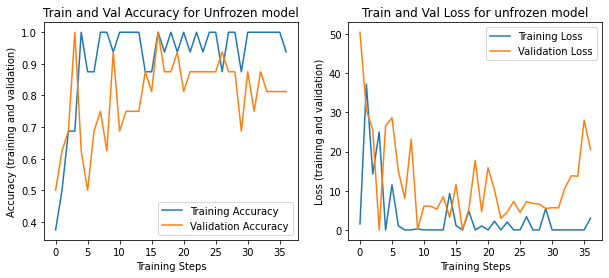

In [ ]:
# For frozen model

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title(f'Train and Val Accuracy for Unfrozen model')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title(f'Train and Val Loss for unfrozen model')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

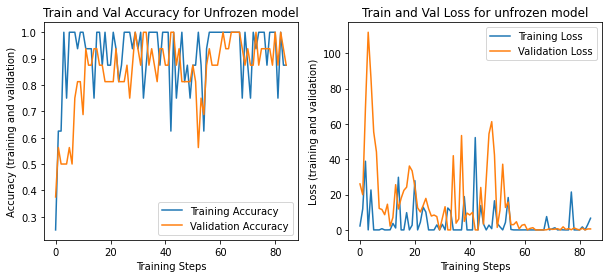

In [ ]:
# for unfrozen model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title(f'Train and Val Accuracy for Unfrozen model')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title(f'Train and Val Loss for unfrozen model')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

1/1 [==============================] - 2s 2s/step
Classification Report
              precision    recall  f1-score   support

      benign       0.83      0.62      0.71         8
   malignant       0.70      0.88      0.78         8

    accuracy                           0.75        16
   macro avg       0.77      0.75      0.75        16
weighted avg       0.77      0.75      0.75        16

1/1 [==============================] - 0s 370ms/step - loss: 15.9020 - accuracy: 0.8125
[15.90199089050293, 0.8125]
Confusion Matrix


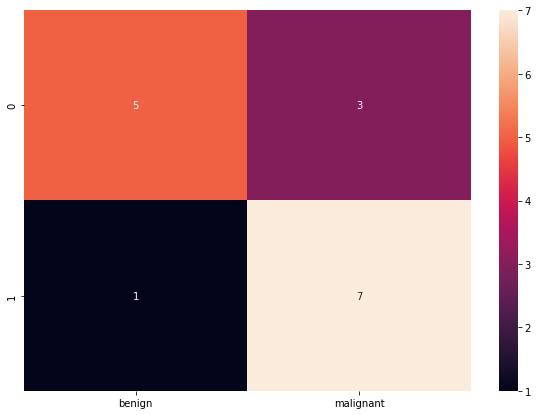

In [ ]:
## For frozen_model

prediction = base_model.predict(validation_generator, steps=len(validation_generator))
y = np.argmax(prediction, axis=1)

print('Classification Report')
cr = classification_report(y_true=validation_generator.classes, y_pred=y, target_names=validation_generator.class_indices)
print(cr)

evaluates = base_model.evaluate(validation_generator)

print(evaluates)

print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y)
df = pd.DataFrame(cm, columns=validation_generator.class_indices)
plt.figure(figsize=(10,7))
sn.heatmap(df, annot=True)

1/1 [==============================] - 0s 283ms/step
Classification Report
              precision    recall  f1-score   support

      benign       1.00      0.88      0.93         8
   malignant       0.89      1.00      0.94         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16

1/1 [==============================] - 0s 372ms/step - loss: 1.7053 - accuracy: 0.8750
[1.7053134441375732, 0.875]
Confusion Matrix


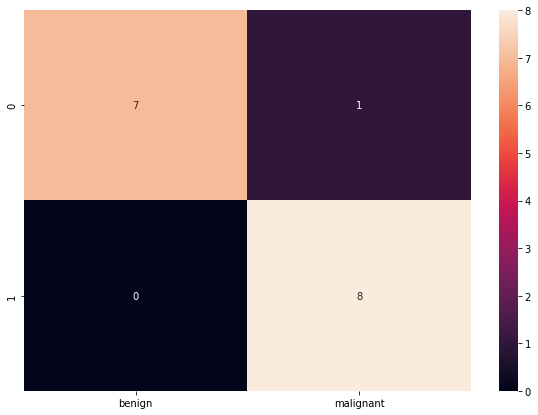

In [ ]:
## For unfrozen_model

prediction = base_model.predict(validation_generator, steps=len(validation_generator))
y = np.argmax(prediction, axis=1)

print('Classification Report')
cr = classification_report(y_true=validation_generator.classes, y_pred=y, target_names=validation_generator.class_indices)
print(cr)

evaluates = base_model.evaluate(validation_generator)

print(evaluates)

print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y)
df = pd.DataFrame(cm, columns=validation_generator.class_indices)
plt.figure(figsize=(10,7))
sn.heatmap(df, annot=True)

In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Conclusion
Unfreezing the model end up having better results. 

In [ ]:
# Conclusion 